We will predict the condition of a hydraulic rig, based on the sensor data provided by the following sensors:
Pressure (5)
Motor power (1)
Volume flow (2)
temperature (4)
Vibration (1)
Colling efficiency (virtual) (1)
Cooling power (virtual) (1)
Efficiency factor (1)

Following is the information about the data set form the provider's readme file:

Condition monitoring of hydraulic systems
=========================================

Abtract: The data set addresses the condition assessment of a hydraulic test rig based on multi sensor data. Four fault types are superimposed with several severity grades impeding selective quantification.

Source:
Creator: ZeMA gGmbH, Eschberger Weg 46, 66121 Saarbrücken
Contact: t.schneider@zema.de, s.klein@zema.de, m.bastuck@lmt.uni-saarland.de, info@lmt.uni-saarland.de

Data Type: Multivariate, Time-Series
Task: Classification, Regression
Attribute Type: Categorical, Real
Area: CS/Engineering
Format Type: Matrix
Does your data set contain missing values? No

Number of Instances: 2205

Number of Attributes: 43680 (8x60 (1 Hz) + 2x600 (10 Hz) + 7x6000 (100 Hz))

Relevant Information:
The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit 
which are connected via the oil tank [1], [2]. 
The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures 
while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied. 

Attribute Information:
The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) 
with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:
Sensor		Physical quantity		Unit		Sampling rate
PS1		Pressure			bar		100 Hz
PS2		Pressure			bar		100 Hz
PS3		Pressure			bar		100 Hz
PS4		Pressure			bar		100 Hz
PS5		Pressure			bar		100 Hz
PS6		Pressure			bar		100 Hz
EPS1		Motor power			W		100 Hz
FS1		Volume flow			l/min		10 Hz
FS2		Volume flow			l/min		10 Hz
TS1		Temperature			°C		1 Hz
TS2		Temperature			°C		1 Hz
TS3		Temperature			°C		1 Hz
TS4		Temperature			°C		1 Hz
VS1		Vibration			mm/s		1 Hz
CE		Cooling efficiency (virtual)	%		1 Hz
CP		Cooling power (virtual)		kW		1 Hz
SE		Efficiency factor		%		1 Hz

The target condition values are cycle-wise annotated in profile.txt (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %:
	3: close to total failure
	20: reduced effifiency
	100: full efficiency

2: Valve condition / %:
	100: optimal switching behavior
	90: small lag
	80: severe lag
	73: close to total failure

3: Internal pump leakage:
	0: no leakage
	1: weak leakage
	2: severe leakage

4: Hydraulic accumulator / bar:
	130: optimal pressure
	115: slightly reduced pressure
	100: severely reduced pressure
	90: close to total failure

5: stable flag:
	0: conditions were stable
	1: static conditions might not have been reached yet



Import the libraries we will need

In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import xgboost as xgb
import os

Import datafiles

In [7]:
dir_path = '/home/mohit/Desktop/HydrualicSystemRig/data'

In [8]:
def get_files(dir_path, filename):
    return pd.read_csv(os.path.join(dir_path, filename), sep='\t', header=None)

Import all pressure sensors data

In [10]:
pressureFile1 = get_files(dir_path=dir_path, filename='PS1.txt')
pressureFile2 = get_files(dir_path=dir_path, filename='PS2.txt')
pressureFile3 = get_files(dir_path=dir_path, filename='PS3.txt')
pressureFile4 = get_files(dir_path=dir_path, filename='PS4.txt')
pressureFile5 = get_files(dir_path=dir_path, filename='PS5.txt')
pressureFile6 = get_files(dir_path=dir_path, filename='PS6.txt')

Import volume flow files

In [11]:
volumeFlow1 = get_files(dir_path=dir_path, filename='FS1.txt')
volumeFlow2 = get_files(dir_path=dir_path, filename='FS2.txt')

Import temperature files

In [12]:
temperature1 = get_files(dir_path=dir_path, filename='TS1.txt')
temperature2 = get_files(dir_path=dir_path, filename='TS2.txt')
temperature3 = get_files(dir_path=dir_path, filename='TS3.txt')
temperature4 = get_files(dir_path=dir_path, filename='TS4.txt')

import rest of the data files: pump efficiency, vibrations, cooling efficiency, coolin power, efficiency factor 

In [14]:
pump1 = get_files(dir_path=dir_path, filename='EPS1.txt')
vibration1 = get_files(dir_path=dir_path, filename='VS1.txt')
coolingE1 = get_files(dir_path=dir_path, filename='CE.txt')
coolingP1 = get_files(dir_path=dir_path, filename='CP.txt')
effFactor1 = get_files(dir_path=dir_path, filename='SE.txt')

Import Label data from profile file

In [15]:
profile = get_files(dir_path=dir_path, filename='profile.txt')

Split the profile into relevent target labels

In [16]:
y_coolerCondition = pd.DataFrame(profile.iloc[:, 0])
y_valveCondition = pd.DataFrame(profile.iloc[:, 1])
y_pumpLeak = pd.DataFrame(profile.iloc[:, 2])
y_hydraulicAcc = pd.DataFrame(profile.iloc[:, 3])
y_stableFlag = pd.DataFrame(profile.iloc[:, 4])

In [17]:
#average the cycle data

def mean_conversion(df):
    df1 = pd.DataFrame()
    df1 = df.mean(axis = 1)
    return df1

In [18]:
PS1 = pd.DataFrame(mean_conversion(pressureFile1))
PS1.columns = ['PS1']

PS2 = pd.DataFrame(mean_conversion(pressureFile2))
PS2.columns = ['PS2']

PS3 = pd.DataFrame(mean_conversion(pressureFile3))
PS3.columns = ['PS3']

PS4 = pd.DataFrame(mean_conversion(pressureFile4))
PS4.columns = ['PS4']

PS5 = pd.DataFrame(mean_conversion(pressureFile5))
PS5.columns = ['PS5']

PS6 = pd.DataFrame(mean_conversion(pressureFile6))
PS6.columns = ['PS6']

FS1 = pd.DataFrame(mean_conversion(volumeFlow1))
FS1.columns = ['FS1']

FS2 = pd.DataFrame(mean_conversion(volumeFlow2))
FS2.columns = ['FS2']

TS1 = pd.DataFrame(mean_conversion(temperature1))
TS1.columns = ['TS1']

TS2 = pd.DataFrame(mean_conversion(temperature2))
TS2.columns = ['TS2']

TS3 = pd.DataFrame(mean_conversion(temperature3))
TS3.columns = ['TS3']

TS4 = pd.DataFrame(mean_conversion(temperature4))
TS4.columns = ['TS4']

P1 = pd.DataFrame(mean_conversion(pump1))
P1.columns = ['P1']

VS1 = pd.DataFrame(mean_conversion(vibration1))
VS1.columns = ['VS1']

CE1 = pd.DataFrame(mean_conversion(coolingE1))
CE1.columns = ['CE1']

CP1 = pd.DataFrame(mean_conversion(coolingP1))
CP1.columns = ['CP1']

SE1 = pd.DataFrame(mean_conversion(effFactor1))
SE1.columns = ['SE1']

In [19]:
#combine all dataframes

X = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef15ab9860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fef15774588>]], dtype=object)

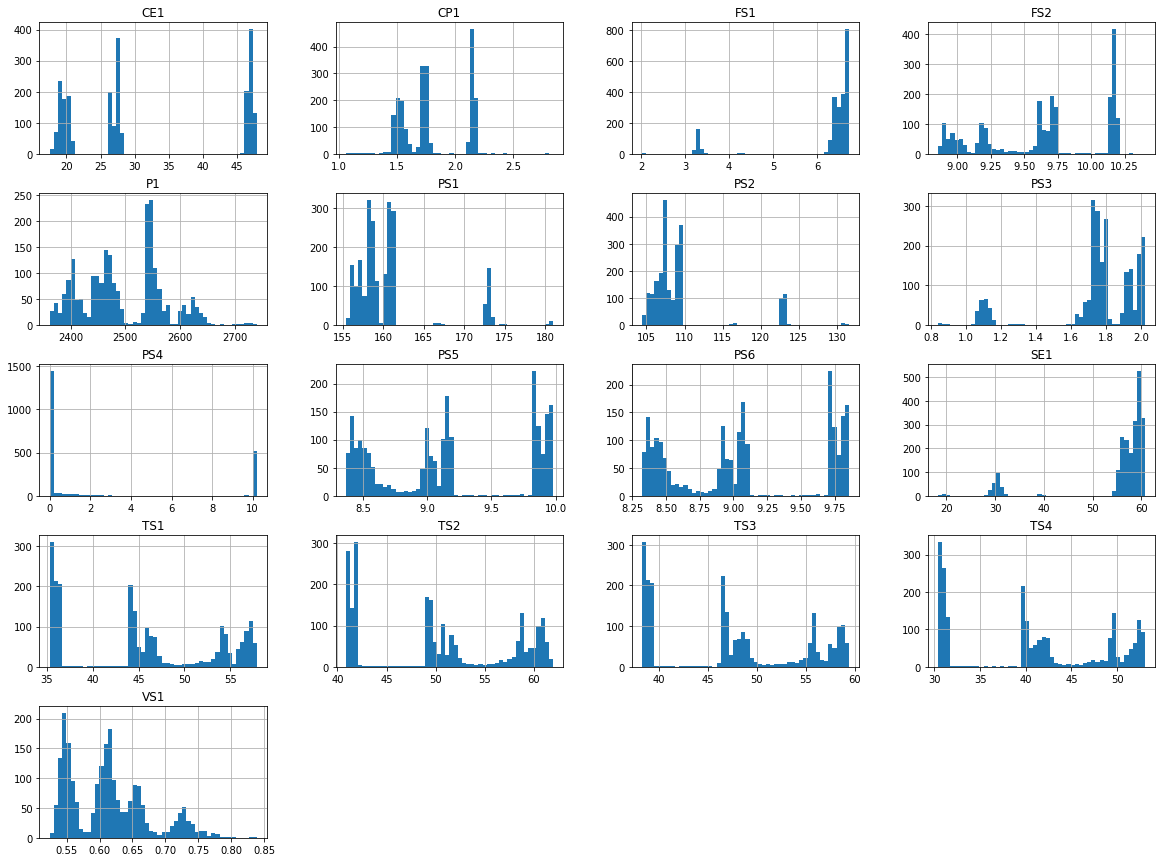

In [22]:
#Lets draw histogram of each value

X.hist(bins=50, figsize=(20, 15))

let's get a correlation matix between various sensor parameters

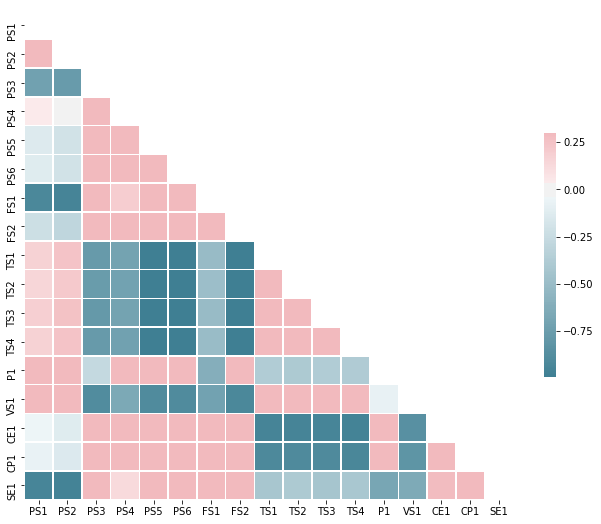

In [60]:
corr_matrix = X.corr()

#plot heat map for correlation matrix (from https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Some of the features seems to be highly correlated. Let's normalize these parameters and do PCA 

Text(0.5,1,'PCA explained variance vs. n componets')

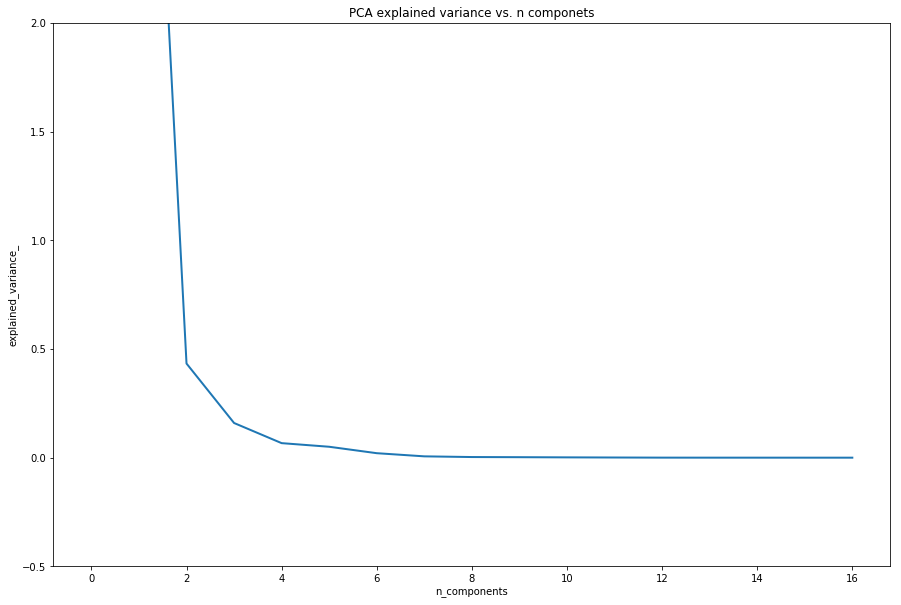

In [67]:
#normalize the X values
X_normalize = StandardScaler().fit_transform(X)

#apply PCA to visulaize the data in cluster
from sklearn.decomposition import PCA
#find explained variance and n_components

pca = PCA()
pca.fit(X_normalize)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.ylim(-0.5, 2)
plt.title('PCA explained variance vs. n componets')

(2205, 17)
(2205, 2)


Text(0.5,1,'Clustering of data when PCA dimension =2')

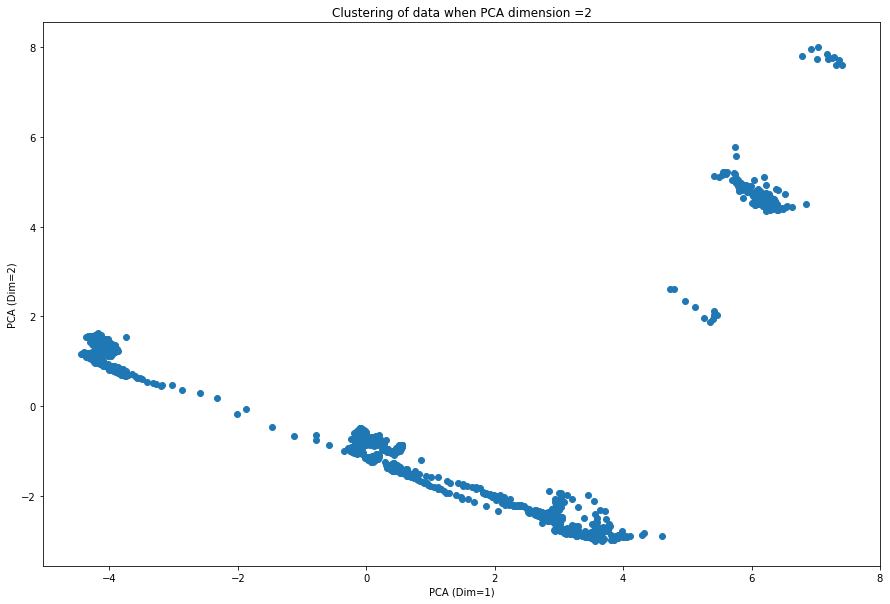

In [66]:
#observe distribution when n_componets =2
pca_2 = PCA(2)
projected = pca_2.fit_transform(X_normalize)
print(X.shape)
print(projected.shape)
plt.figure(figsize=(15, 10))
plt.scatter(projected[:, 0], projected[:,1])
plt.xlabel('PCA (Dim=1)')
plt.ylabel('PCA (Dim=2)')
plt.title('Clustering of data when PCA dimension =2')


Let's define a model to predcit values

In [70]:
def predict_pump_performance(X, y, predictType):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=24)
    
    #we will use xgboost to do the classification
    seed= 24
    xgb1 = xgb.sklearn.XGBClassifier(
            learning_rate =0.1,
             n_estimators=100,
             max_depth=5,
             min_child_weight=11,
             gamma=0.1,
             subsample=0.8,
             colsample_bytree=0.7,
             objective='multi:softprob',
             n_jobs=-1,
             scale_pos_weight=1,
             seed=seed)
    
    xgb1.fit(X_train, y_train)
    
    y_pred= xgb1.predict(X_val)
    
    #confusion matrix and classification report
    
    cm = confusion_matrix(y_val, y_pred)
    
    print(classification_report(y_val, y_pred))
    
    
    fig, ax = plt.subplots(figsize = (15, 10))
    ind = np.arange(17)
    width = 0.15
    feature_importtance = xgb1.feature_importances_
    rect1 = ax.bar(ind+width, feature_importtance)
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'P1', 'VS1', 'CE1', 'CP1', 'SE1'))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Measurements')
    ax.set_title('Relative Imporatnce of various measurements to predict ' + predictType)
    #plt.show()

/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          3       1.00      1.00      1.00        82
         20       1.00      1.00      1.00        70
        100       1.00      1.00      1.00        69

avg / total       1.00      1.00      1.00       221



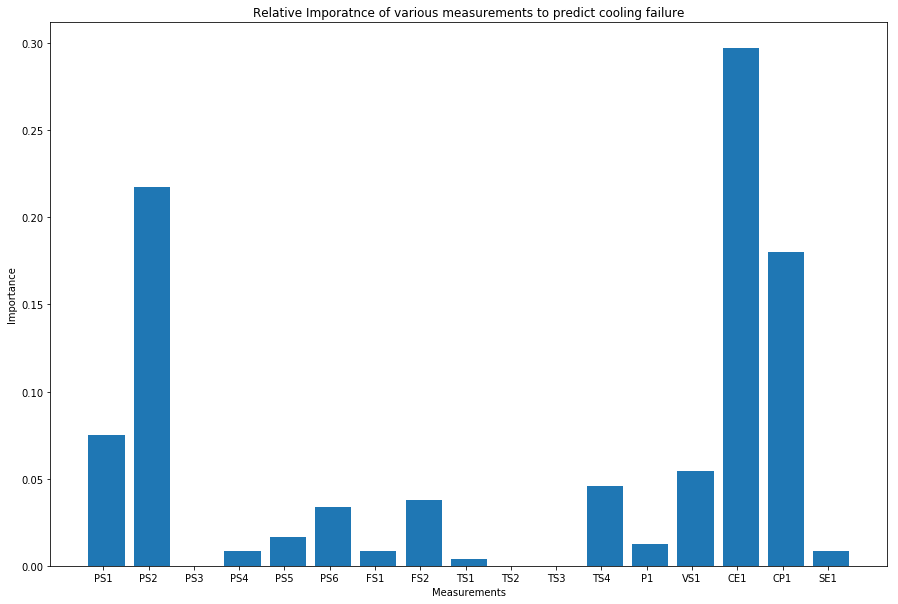

In [71]:
#let's predict the cooling failure
predict_pump_performance(X_normalize, y_coolerCondition, 'cooling failure')


Since we looking for cooling performance it make sense that the cooling efficiency and colling power are important features. Seems like pressure sensors 1 and 2 are also important, most likely due to pumping more coolant to maintain the pump at desired temperatures.

Let's predict valve condition

/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

         73       0.95      1.00      0.97        39
         80       1.00      0.95      0.97        41
         90       0.89      0.77      0.83        31
        100       0.94      0.97      0.96       110

avg / total       0.95      0.95      0.94       221



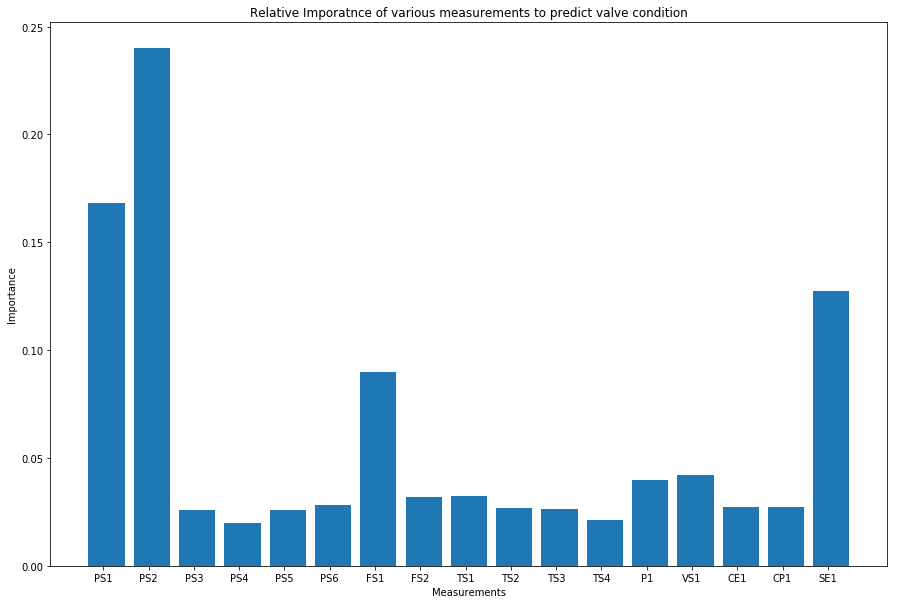

In [72]:
predict_pump_performance(X_normalize, y_valveCondition, 'valve condition')

Here volume flow is an important feature, as switching behavior of the valve might be affecting the flow of hydraulic fluid

Let's predict pump leaks

/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.99      1.00       125
          1       0.98      0.98      0.98        54
          2       0.98      1.00      0.99        42

avg / total       0.99      0.99      0.99       221



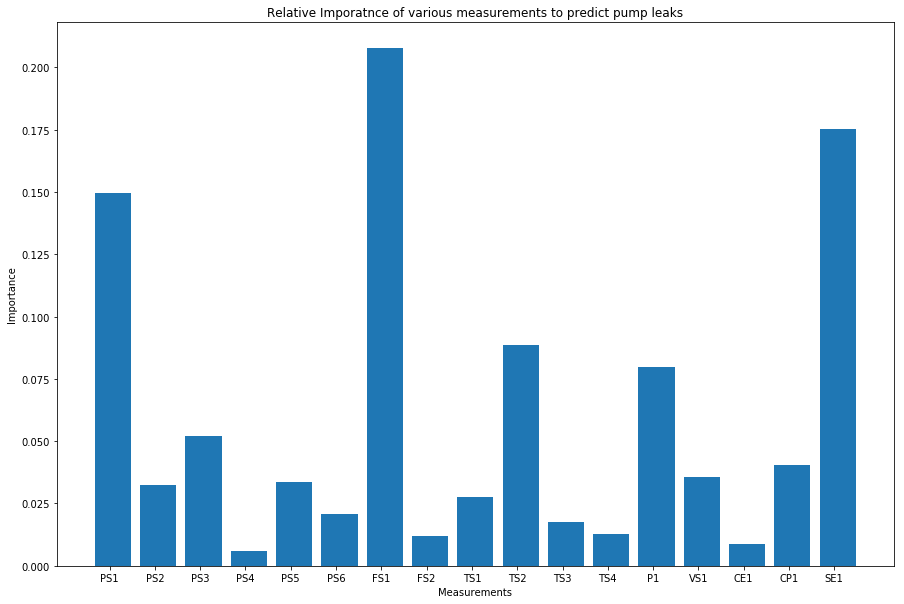

In [73]:
predict_pump_performance(X_normalize, y_pumpLeak, 'pump leaks')

Here again voulme flow is an important feature as leaking pump can have severe effect of the flow of hydraulic fluid. Addtionally, efficiency factor is important as sever leak will have an effect on the efficiency of the rig.

Let's predict hydrualic accumulator condition

/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mohit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

         90       0.99      0.94      0.96        78
        100       0.92      0.95      0.94        38
        115       0.90      1.00      0.95        36
        130       1.00      0.99      0.99        69

avg / total       0.97      0.96      0.96       221



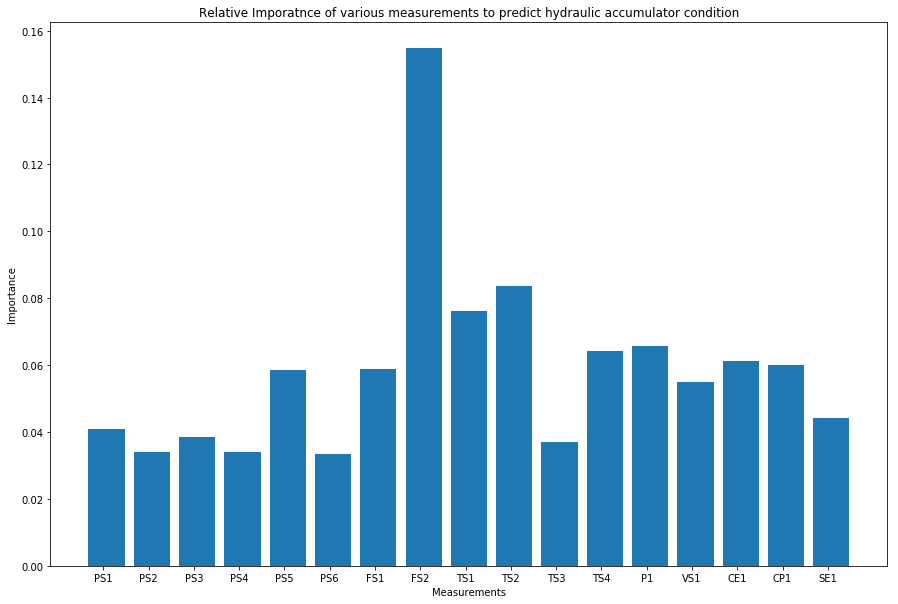

In [74]:
predict_pump_performance(X_normalize, y_hydraulicAcc, 'hydraulic accumulator condition')

In the case of hydraulic accumulator condition, seems like volume flow is an important feature, but rest of the features are also important.

Conclusions:

We are able to predict various pump failure conditions, with a very high level of accuracy (F1 score > 0.94 in all cases and > 0.99 in 2 cases)